# Non-uniform weighting for quadratic power spectrum estimation

Zheng Zhang

28 September 2025

In [ ]:
import hera_pspec as hp
import numpy as np
from scipy import special, integrate
import uvtools.dspec as dspec
from hera_pspec import uvwindow, conversions
from astropy import constants


def trace_AB(A, B):
    """
    Compute the trace of the matrix product A @ B.T efficiently.
    """
    return np.sum(A*B.T)

def example_beam():
    """
    Load example beam pattern data from saved file.
    
    Loads normalized beam response pattern and solid angle element
    from 'fromKaifeng/beam_info.npz'. The beam is normalized by the
    primary beam solid angle Omega_p.
    
    Returns
    -------
    beam : ndarray
        Normalized beam response of shape (N_freqs, N_directions)
        Units: dimensionless (normalized by Omega_p)
    d_Omega : float
        Solid angle element for numerical integration over directions
        Units: steradians
        
    Notes
    -----
    The beam file should contain:
    - arr_0: beam response array
    - arr_1: beam_omega (complex, real part used)
    - arr_2: N parameter for solid angle calculation
    """
    _ = np.load("fromKaifeng/beam_info.npz")
    beam, beam_omega, N = (_['arr_0'], _['arr_1'], _['arr_2'])

    omega_p = beam_omega.real

    beam = beam/omega_p[:, None]
    d_Omega = np.pi/(3.*N*N)

    return beam, d_Omega

test_beam, test_d_Omega = example_beam()

def generate_freq_weights(flag1, flag2, return_matrix=False, method_func=None):
    '''
    method_func: function to generate weights given flag arrays.
    '''
    if method_func is not None:
        weight1 = method_func(flag1)
        weight2 = method_func(flag2)
    else:
        weight1 = flag1
        weight2 = flag2
    if return_matrix:
        return np.einsum('i,j->ij', weight1, weight2.conj())
    return weight1, weight2

def get_quad_Fourier_list(Ndlys, d_eta):

    Q_alt_li = []
    Nfreqs = Ndlys

    for mode in range(Ndlys):

        if Ndlys % 2 == 0:
            start_idx = -Ndlys/2
        else:
            start_idx = -(Ndlys - 1)/2
        m = (start_idx + mode) * np.arange(Nfreqs)
        m = np.exp(-2j * np.pi * m / Ndlys) * d_eta
        Q_alt = np.einsum('i,j', m.conj(), m) # dot it with its conjugate
        Q_alt_li.append(Q_alt)

    return Q_alt_li

def generate_quad_Beam(normalised_beam, d_Omega=1.0, isotropic_signal=False):
    """
    normalised_beam: shape (N_freqs, N_directions) - Beam response normalized by Omega_p
        dType: np.ndarray (real or complex with zero imaginary part)
    d_Omega: float, solid angle element for each direction
    isotropic_signal: bool, if True, assumes isotropic signal and integrates over directions first
        This is just for testing purposes

    Returns:
    quad_Beam: shape (N_freqs, N_freqs)
    """
    if not isotropic_signal:
        # Vectorized computation: sum over directions
        quad_Beam = np.einsum('if,jf->ij', normalised_beam, normalised_beam) * d_Omega
        return quad_Beam
    else:
        normalised_beam_int = np.sum(normalised_beam, axis=1) * d_Omega
        quad_Beam = np.einsum('i,j->ij', normalised_beam_int, normalised_beam_int)
        return quad_Beam

def generate_response_matrix(quad_Fourier_list, quad_Weights, quad_Beam):
    """
    Vectorized version - eliminates the loop entirely
    """
    # Convert list to 3D array: (n_modes, n_freqs, n_freqs)
    quad_Fourier_array = np.array(quad_Fourier_list)
    
    # Broadcast multiplication: aux is (n_freqs, n_freqs), quad_Fourier_array is (n_modes, n_freqs, n_freqs)
    aux = quad_Weights * quad_Beam
    resp_mat_array = aux[None, :, :] * quad_Fourier_array

    return resp_mat_array

def generate_window_func(quad_form_mat, resp_mat_list):
    window = np.array([ trace_AB(quad_form_mat, R) for R in resp_mat_list ])
    norm = np.sum(window)
    return window/norm, norm

def evaluate_bias(quad_form_mat, quad_Weights, norm, noise_cov=None):
    if noise_cov is None:
        return 0.0
    weighted_Ncov = noise_cov * quad_Weights
    bias = trace_AB(quad_form_mat, weighted_Ncov) / norm
    return bias

class QE_window:
    def __init__(self, 
                 freqs, 
                 normalised_beam=test_beam, 
                 d_Omega=test_d_Omega, 
                 ):
    
        df = np.median(np.diff(freqs))
        self.Ndlys = freqs.size
        delays = np.fft.fftshift(np.fft.fftfreq(self.Ndlys, d=df)) # Delay coordinates, in sec
        d_eta = np.median(np.diff(delays))

        self.quad_Fourier_list =get_quad_Fourier_list(self.Ndlys, d_eta)
        self.quad_Beam = generate_quad_Beam(normalised_beam, d_Omega=d_Omega)

    def generate_window_coeffs(self, weight1, weight2, quad_form="Q"):
        """
        weight1, weight2: shape (N_freqs,)
        quad_form: "Q" or "Q_alt"
        """
        quad_Weights = np.einsum('i,j->ij', weight1, weight2.conj())
        resp_mat_arr = generate_response_matrix(self.quad_Fourier_list, quad_Weights, self.quad_Beam)
        
        if quad_form == "Q":
            quad_form_matrices = resp_mat_arr
        elif quad_form == "Q_alt":
            quad_form_matrices = self.quad_Fourier_list
        wind_coeffs_li = []
        for i in range(self.Ndlys):
            wind_coeffs, norm = generate_window_func(quad_form_matrices[i], resp_mat_arr)
            wind_coeffs_li.append(wind_coeffs)
        return np.array(wind_coeffs_li)



In [2]:
def apodize_around_flags(flag_arr, ramp_width):
    """
    flag_arr : boolean array (True = flagged, False = good)
    ramp_width : integer number of samples for the half-cosine ramp on each side
    returns apod : float array in [0,1] same length as flag_arr
    """
    mask = ~flag_arr  # Convert to True=good, False=flagged
    n = len(mask)
    apod = mask.astype(float).copy()

    # find contiguous flagged segments
    diffs = np.diff(np.r_[0, mask.astype(int), 0])
    starts = np.where(diffs == -1)[0]  # start index of flagged seg
    ends   = np.where(diffs == 1)[0]   # end index (exclusive) of flagged seg

    for s, e in zip(starts, ends):
        # left ramp: from s-ramp_width .. s-1 rises from 1 -> 0
        L = ramp_width
        if L > 0:
            left0 = max(0, s - L)
            left_len = s - left0
            if left_len > 0:
                t = np.arange(left_len) / left_len  # 0..1
                apod[left0:s] *= 0.5*(1 + np.cos(np.pi * (t)))  # half-cosine taper

            # right ramp: from e .. e+L-1 falls from 0 -> 1
            right1 = min(n, e + L)
            right_len = right1 - e
            if right_len > 0:
                t = np.arange(right_len) / right_len  # 0..1
                apod[e:right1] *= 0.5*(1 - np.cos(np.pi * (t)))  # inverted half-cosine

        # set flagged region to 0
        apod[s:e] = 0.0

    # small numerical safety
    apod = np.clip(apod, 0.0, 1.0)
    return apod

def taper_apodised_flags(flag_arr, ramp_width, taper_coeffs=None):
    """
    Combines apodization around flags with a global tapering window.
    flag_arr : boolean array (True = flagged, False = good)
    ramp_width : integer number of samples for the half-cosine ramp on each side
    taper_coeffs : optional float array in [0,1] same length as flag_arr
                    if None, uses Blackman-Harris window
    returns apod_taper : float array in [0,1] same length as flag_arr
    """
    n = len(flag_arr)
    if taper_coeffs is None:
        import uvtools.dspec as dspec
        taper_coeffs = dspec.gen_window('blackman-harris', n)

    apod = apodize_around_flags(flag_arr, ramp_width)

    apod_taper = apod * taper_coeffs

    # small numerical safety
    apod_taper = np.clip(apod_taper, 0.0, 1.0)
    return apod_taper

In [ ]:
freqs_pspec, data_ee, data_nsample, data_ee_auto = np.load("fromKaifeng/vis.npy").T
freqs_pspec = freqs_pspec.real
data_nsample = data_nsample.real
Nfreqs = freqs_pspec.size
flag1 = ~data_nsample.astype(bool)
flag2 = flag1[::-1] # Reverse flag1 as flag2 for testing

In [4]:
import matplotlib.pyplot as plt

def plot_with_log_and_dash(ax, y_vals, label, color=None):
    """Plot function with log scale and dashed lines for negative values"""
    y_vals = np.array(y_vals)
    x_vals = np.arange(len(y_vals))
    
    # Plot positive values as solid lines
    pos_mask = y_vals > 0
    if np.any(pos_mask):
        ax.semilogy(x_vals[pos_mask], y_vals[pos_mask], label=f"{label}", 
                   linewidth=2, linestyle='-', color=color, alpha=0.7)
    
    # Plot absolute value of negative values as dashed lines
    neg_mask = y_vals < 0
    if np.any(neg_mask):
        ax.semilogy(x_vals[neg_mask], np.abs(y_vals[neg_mask]), label=f"{label} (neg)", 
                   linewidth=2, linestyle='--', color=color, alpha=0.7)

In [5]:
# Initialize the Quadratic Estimator window function object

test_obj = QE_window(freqs_pspec)

## 1. Window function analysis (with no flags)

In [6]:
import uvtools.dspec as dspec

weight1_uni = np.ones(Nfreqs)
weight1_taper = dspec.gen_window('blackman-harris', Nfreqs)

weight2_uni = np.ones(Nfreqs)
weight2_taper = dspec.gen_window('blackman-harris', Nfreqs)

# Generate the window functions
windows_uni_Q = test_obj.generate_window_coeffs(weight1_uni, weight2_uni, quad_form="Q")
windows_uni_Q_alt = test_obj.generate_window_coeffs(weight1_uni, weight2_uni, quad_form="Q_alt")

windows_taper_Q = test_obj.generate_window_coeffs(weight1_taper, weight2_taper, quad_form="Q")
windows_taper_Q_alt = test_obj.generate_window_coeffs(weight1_taper, weight2_taper, quad_form="Q_alt")


Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


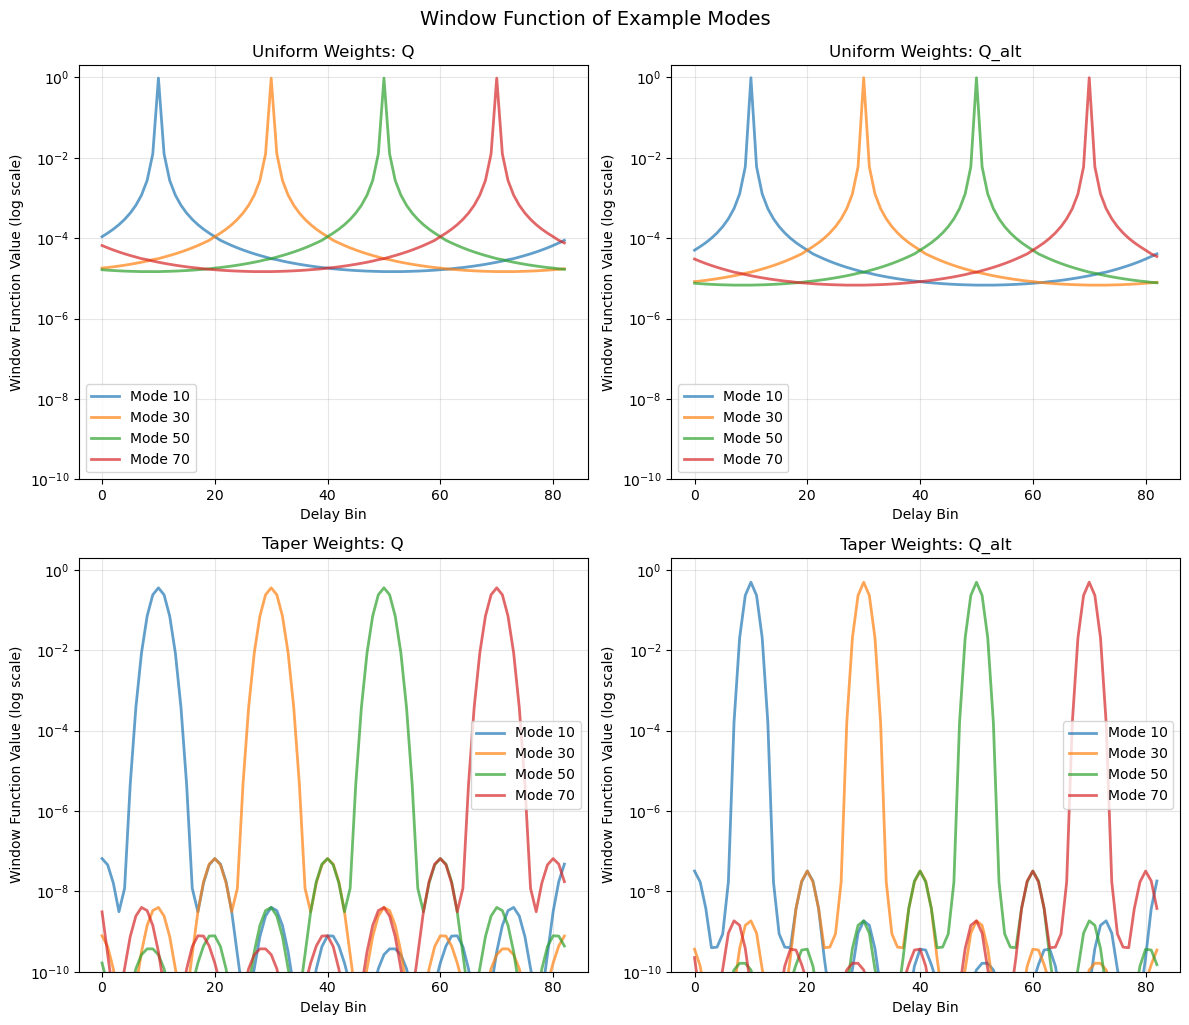

In [7]:
# Sample indices (of delay modes) for visualisation
inds = [10, 30, 50, 70]
colors = ['C0', 'C1', 'C2', 'C3']
labels = [f"Mode {i}" for i in inds]

y_min, y_max = 1e-10, 2.0

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Panel 1: Uniform Window, Q
for i, color, label in zip(inds, colors, labels):
    plot_with_log_and_dash(ax1, windows_uni_Q[i], label, color=color)
ax1.set_xlabel("Delay Bin")
ax1.set_ylabel("Window Function Value (log scale)")
ax1.set_ylim(y_min, y_max)
ax1.set_title("Uniform Weights: Q")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Uniform Window, Q_alt
for i, color, label in zip(inds, colors, labels):
    plot_with_log_and_dash(ax2, windows_uni_Q_alt[i], label, color=color)
ax2.set_xlabel("Delay Bin")
ax2.set_ylabel("Window Function Value (log scale)")
ax2.set_ylim(y_min, y_max)
ax2.set_title("Uniform Weights: Q_alt")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Panel 3: Taper Window, Q
for i, color, label in zip(inds, colors, labels):
    plot_with_log_and_dash(ax3, windows_taper_Q[i], label, color=color)
ax3.set_xlabel("Delay Bin")
ax3.set_ylabel("Window Function Value (log scale)")
ax3.set_ylim(y_min, y_max)
ax3.set_title("Taper Weights: Q")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Panel 4: Taper Window, Q_alt
for i, color, label in zip(inds, colors, labels):
    plot_with_log_and_dash(ax4, windows_taper_Q_alt[i], label, color=color)
ax4.set_xlabel("Delay Bin")
ax4.set_ylabel("Window Function Value (log scale)")
ax4.set_ylim(y_min, y_max)
ax4.set_title("Taper Weights: Q_alt")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f"Window Function of Example Modes", fontsize=14, y=1.02)
plt.show()

## 2. Window function analysis (with flags)

We are going to try out different weighting functions for the flagged data.
As we will see, the 'flag + apodisation around flag + tapering' method is the most effective.

In [8]:

weight1_flag = ~flag1
weight1_flag_taper = weight1_flag * weight1_taper
weight1_flag_apod = apodize_around_flags(flag1, ramp_width=10)
weight1_flag_apod_taper = taper_apodised_flags(flag1, ramp_width=10)

weight2_flag = ~flag2
weight2_flag_taper = weight2_flag * weight2_taper
weight2_flag_apod = apodize_around_flags(flag2, ramp_width=10)
weight2_flag_apod_taper = taper_apodised_flags(flag2, ramp_width=10)

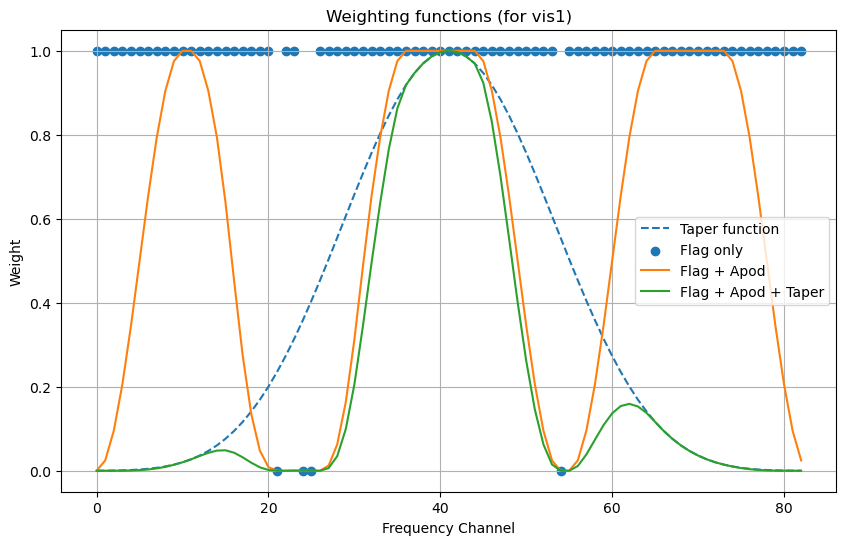

In [9]:
# Visualise different weighting schemes
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
# plt.plot(weight1_uni, label='Uniform')
plt.plot(weight1_taper, label='Taper function', linestyle='--')
plt.scatter(np.arange(Nfreqs), weight1_flag, label='Flag only')
# plt.plot(weight1_flag_taper, label='Flag + Taper')
plt.plot(weight1_flag_apod, label='Flag + Apod')
plt.plot(weight1_flag_apod_taper, label='Flag + Apod + Taper')
plt.legend()
plt.xlabel('Frequency Channel')
plt.ylabel('Weight')
plt.title('Weighting functions (for vis1)')
plt.grid()
plt.show()

In [10]:
# Generate the window functions
windows_flag_Q = test_obj.generate_window_coeffs(weight1_flag, weight2_flag, quad_form="Q")
windows_flag_Q_alt = test_obj.generate_window_coeffs(weight1_flag, weight2_flag, quad_form="Q_alt")

windows_flag_taper_Q = test_obj.generate_window_coeffs(weight1_flag_taper, weight2_flag_taper, quad_form="Q")
windows_flag_taper_Q_alt = test_obj.generate_window_coeffs(weight1_flag_taper, weight2_flag_taper, quad_form="Q_alt")

windows_flag_apod_Q = test_obj.generate_window_coeffs(weight1_flag_apod, weight2_flag_apod, quad_form="Q")
windows_flag_apod_Q_alt = test_obj.generate_window_coeffs(weight1_flag_apod, weight2_flag_apod, quad_form="Q_alt")

windows_flag_apod_taper_Q = test_obj.generate_window_coeffs(weight1_flag_apod_taper, weight2_flag_apod_taper, quad_form="Q")
windows_flag_apod_taper_Q_alt = test_obj.generate_window_coeffs(weight1_flag_apod_taper, weight2_flag_apod_taper, quad_form="Q_alt")

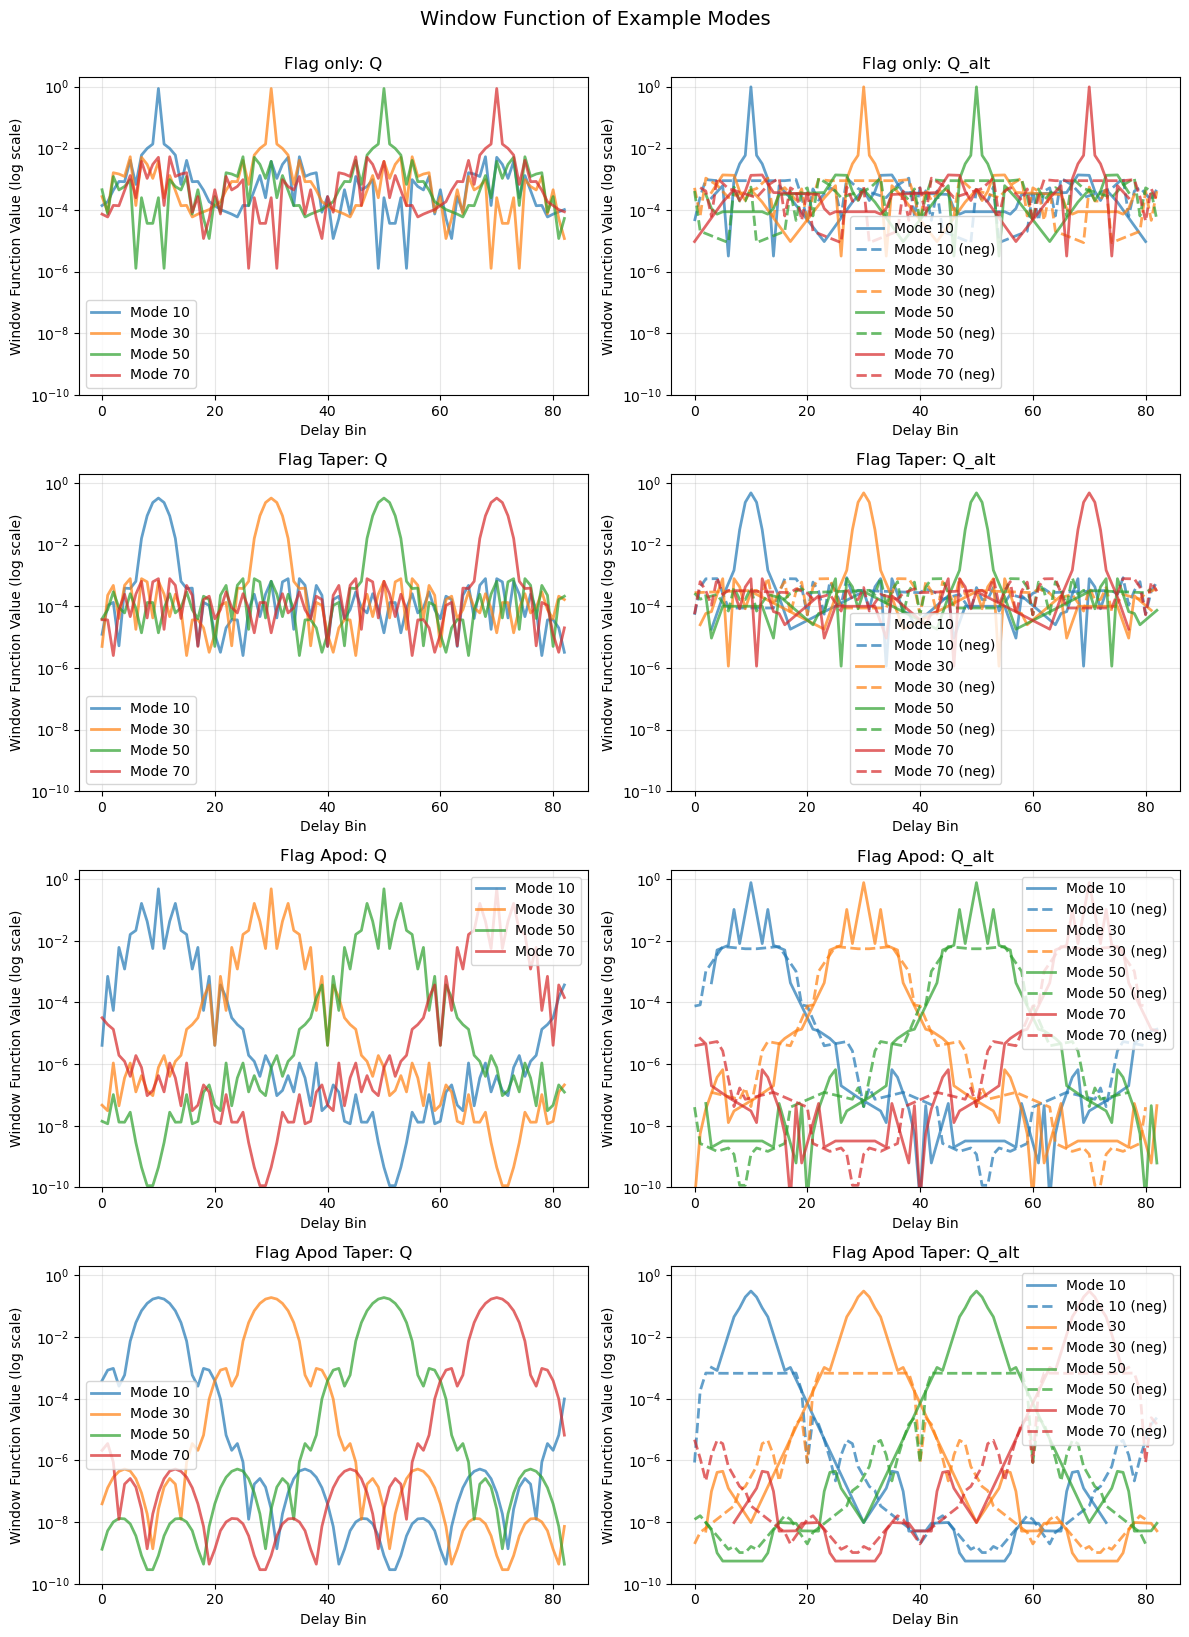

In [11]:
# Sample indices (of delay modes) for visualisation
inds = [10, 30, 50, 70]
colors = ['C0', 'C1', 'C2', 'C3']
labels = [f"Mode {i}" for i in inds]

y_min, y_max = 1e-10, 2.0

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(12, 16))

# Panel 1: Flag, Q
for i, color, label in zip(inds, colors, labels):
    plot_with_log_and_dash(ax1, windows_flag_Q[i], label, color=color)
ax1.set_xlabel("Delay Bin")
ax1.set_ylabel("Window Function Value (log scale)")
ax1.set_ylim(y_min, y_max)
ax1.set_title("Flag only: Q")
ax1.legend()
ax1.grid(True, alpha=0.3)
# Panel 2: Flag, Q_alt
for i, color, label in zip(inds, colors, labels):
    plot_with_log_and_dash(ax2, windows_flag_Q_alt[i], label, color=color)
ax2.set_xlabel("Delay Bin")
ax2.set_ylabel("Window Function Value (log scale)")
ax2.set_ylim(y_min, y_max)
ax2.set_title("Flag only: Q_alt")
ax2.legend()
ax2.grid(True, alpha=0.3)
# Panel 3: Flag Taper, Q
for i, color, label in zip(inds, colors, labels):
    plot_with_log_and_dash(ax3, windows_flag_taper_Q[i], label, color=color)
ax3.set_xlabel("Delay Bin")
ax3.set_ylabel("Window Function Value (log scale)")
ax3.set_ylim(y_min, y_max)
ax3.set_title("Flag Taper: Q")
ax3.legend()
ax3.grid(True, alpha=0.3)
# Panel 4: Flag Taper, Q_alt
for i, color, label in zip(inds, colors, labels):
    plot_with_log_and_dash(ax4, windows_flag_taper_Q_alt[i], label, color=color)
ax4.set_xlabel("Delay Bin")
ax4.set_ylabel("Window Function Value (log scale)")
ax4.set_ylim(y_min, y_max)
ax4.set_title("Flag Taper: Q_alt")
ax4.legend()
ax4.grid(True, alpha=0.3)
# Panel 5: Flag Apod, Q
for i, color, label in zip(inds, colors, labels):
    plot_with_log_and_dash(ax5, windows_flag_apod_Q[i], label, color=color)
ax5.set_xlabel("Delay Bin")
ax5.set_ylabel("Window Function Value (log scale)")
ax5.set_ylim(y_min, y_max)
ax5.set_title("Flag Apod: Q")
ax5.legend()
ax5.grid(True, alpha=0.3)
# Panel 6: Flag Apod, Q_alt
for i, color, label in zip(inds, colors, labels):
    plot_with_log_and_dash(ax6, windows_flag_apod_Q_alt[i], label, color=color)
ax6.set_xlabel("Delay Bin")
ax6.set_ylabel("Window Function Value (log scale)") 
ax6.set_ylim(y_min, y_max)
ax6.set_title("Flag Apod: Q_alt")
ax6.legend()
ax6.grid(True, alpha=0.3)
# Panel 7: Flag Apod Taper, Q
for i, color, label in zip(inds, colors, labels):
    plot_with_log_and_dash(ax7, windows_flag_apod_taper_Q[i], label, color=color)
ax7.set_xlabel("Delay Bin")
ax7.set_ylabel("Window Function Value (log scale)")
ax7.set_ylim(y_min, y_max)
ax7.set_title("Flag Apod Taper: Q")
ax7.legend()
ax7.grid(True, alpha=0.3)
# Panel 8: Flag Apod Taper, Q_alt
for i, color, label in zip(inds, colors, labels):
    plot_with_log_and_dash(ax8, windows_flag_apod_taper_Q_alt[i], label, color=color)
ax8.set_xlabel("Delay Bin")
ax8.set_ylabel("Window Function Value (log scale)")
ax8.set_ylim(y_min, y_max)
ax8.set_title("Flag Apod Taper: Q_alt")
ax8.legend()
ax8.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f"Window Function of Example Modes", fontsize=14, y=1.02)
plt.show()

Note that the 'Q_alternative' case provides complex weights. 
This is because 'vis1' and 'vis2' have different flags (and therefore different weights), whereas 'Q_alternative' only involves the Fourier transform and does not include the weights.


### 2.1 Test different width for the half-cosine ramp on each side of flags

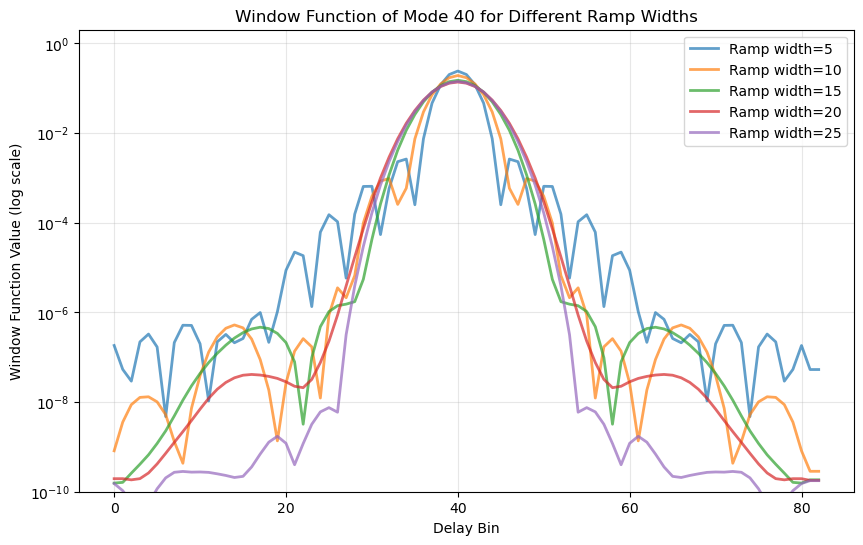

In [12]:
weight1_flag_apod_taper_5 = taper_apodised_flags(flag1, ramp_width=5)
weight2_flag_apod_taper_5 = taper_apodised_flags(flag2, ramp_width=5)
windows_flag_apod_taper_Q_5 = test_obj.generate_window_coeffs(weight1_flag_apod_taper_5, weight2_flag_apod_taper_5, quad_form="Q")

weight1_flag_apod_taper_10 = taper_apodised_flags(flag1, ramp_width=10)
weight2_flag_apod_taper_10 = taper_apodised_flags(flag2, ramp_width=10)
windows_flag_apod_taper_Q_10 = test_obj.generate_window_coeffs(weight1_flag_apod_taper_10, weight2_flag_apod_taper_10, quad_form="Q")

weight1_flag_apod_taper_15 = taper_apodised_flags(flag1, ramp_width=15)
weight2_flag_apod_taper_15 = taper_apodised_flags(flag2, ramp_width=15)
windows_flag_apod_taper_Q_15 = test_obj.generate_window_coeffs(weight1_flag_apod_taper_15, weight2_flag_apod_taper_15, quad_form="Q")

weight1_flag_apod_taper_20 = taper_apodised_flags(flag1, ramp_width=20)
weight2_flag_apod_taper_20 = taper_apodised_flags(flag2, ramp_width=20)
windows_flag_apod_taper_Q_20 = test_obj.generate_window_coeffs(weight1_flag_apod_taper_20, weight2_flag_apod_taper_20, quad_form="Q")

weight1_flag_apod_taper_25 = taper_apodised_flags(flag1, ramp_width=25)
weight2_flag_apod_taper_25 = taper_apodised_flags(flag2, ramp_width=25)
windows_flag_apod_taper_Q_25 = test_obj.generate_window_coeffs(weight1_flag_apod_taper_25, weight2_flag_apod_taper_25, quad_form="Q")


# Sample index (of delay modes) for visualisation
ind = 40

plt.figure(figsize=(10,6))
plot_with_log_and_dash(plt.gca(), windows_flag_apod_taper_Q_5[ind], label='Ramp width=5')
plot_with_log_and_dash(plt.gca(), windows_flag_apod_taper_Q_10[ind], label='Ramp width=10')
plot_with_log_and_dash(plt.gca(), windows_flag_apod_taper_Q_15[ind], label='Ramp width=15')
plot_with_log_and_dash(plt.gca(), windows_flag_apod_taper_Q_20[ind], label='Ramp width=20')
plot_with_log_and_dash(plt.gca(), windows_flag_apod_taper_Q_25[ind], label='Ramp width=25')
plt.xlabel('Delay Bin')
plt.ylabel('Window Function Value (log scale)')
plt.ylim(1e-10, 2.0)
plt.title(f'Window Function of Mode {ind} for Different Ramp Widths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()  

### Clearly, the wider the ramp, the better!

## 3. Quadratic Extimator with Non-uniform Weights

In [ ]:
class nonuniform_pspec:
    def __init__(self, freqs, normalised_beam=test_beam,
                 d_Omega=test_d_Omega, taper='blackman-harris',
                 test_with_isotropic_signal=True
                 ):
        self.Nfreqs = freqs.size
        self.Ndlys = freqs.size

        self.taper = taper
        if self.taper == 'none':
            self.taper_func = np.ones(self.Nfreqs)
        else:
            self.taper_func = dspec.gen_window(self.taper, self.Nfreqs)

        df = np.median(np.diff(freqs))
        
        delays = np.fft.fftshift(np.fft.fftfreq(self.Ndlys, d=df)) # Delay coordinates, in sec
        self.d_eta = np.median(np.diff(delays))

        self.quad_Fourier_list =get_quad_Fourier_list(self.Ndlys, self.d_eta)
        if normalised_beam is None or d_Omega is None:
            self.quad_Beam = np.ones((self.Nfreqs, self.Nfreqs))
        else:
            self.quad_Beam = generate_quad_Beam(normalised_beam, d_Omega=d_Omega, isotropic_signal=test_with_isotropic_signal)

    def p_hat(self, vis1, vis2, flag1, flag2, N_cov=None, weight1=None, weight2=None, ramp_width=20, quad_form="Q"):
        """
        weight1, weight2: shape (N_freqs,)
        quad_form: "Q" or "Q_alt" or provided matrices
        """
        N_cov = N_cov

        if weight1 is None:
            weight1 = taper_apodised_flags(flag1, ramp_width, taper_coeffs=self.taper_func)
        if weight2 is None:
            weight2 = taper_apodised_flags(flag2, ramp_width, taper_coeffs=self.taper_func)

        weighted_vis1 = vis1 * weight1
        weighted_vis2 = vis2 * weight2
        Dmat = np.einsum('i,j->ij', weighted_vis1, weighted_vis2.conj())

        quad_Weights = np.einsum('i,j->ij', weight1, weight2.conj())
        self.resp_mat_arr = generate_response_matrix(self.quad_Fourier_list, quad_Weights, self.quad_Beam)
        
        
        if quad_form == "Q":
            quad_form_matrices = self.resp_mat_arr
        elif quad_form == "Q_alt":
            quad_form_matrices = self.quad_Fourier_list
        else: 
            quad_form_matrices = quad_form # Assume user provided valid matrices
        wind_coeffs_li = []
        norm_li = []
        bias_li = []
        p_hat_li = []
        for i in range(self.Ndlys):
            wind_coeffs, norm_factor = generate_window_func(quad_form_matrices[i], self.resp_mat_arr)
            wind_coeffs_li.append(wind_coeffs)
            bias = evaluate_bias(quad_form_matrices[i], quad_Weights, norm_factor, noise_cov=N_cov)
            p_hat_i = trace_AB(quad_form_matrices[i], Dmat) / norm_factor - bias
            p_hat_li.append(p_hat_i)
            bias_li.append(bias)
            norm_li.append(norm_factor)

        return np.array(wind_coeffs_li), np.array(bias_li), np.array(norm_li), np.array(p_hat_li)


def calculate_p_hat_covariance(bps, resp_mat_arr, norm_li, weighted_noise_cov=None):
    """

    bps: array of bandpowers, shape (Ndlys,)
    resp_mat_arr: array of response matrices, shape (Ndlys, Nfreqs, Nfreqs)
    norm
    weighted_noise_cov: optional weighted noise covariance matrix, shape (Nfreqs, Nfreqs)
    returns var_p: covariance matrix of bandpower estimates, shape (Ndlys, Ndlys)
    """
    Ndlys = resp_mat_arr.shape[0]
    if weighted_noise_cov is not None:
        # Initialize data_cov as deep copy of weighted_noise_cov
        data_cov = weighted_noise_cov.copy()
    else:
        data_cov = np.zeros((Ndlys, Ndlys), dtype=np.complex128)
    for i in range(Ndlys):
        bandpower = bps[i].real
        data_cov += bandpower * resp_mat_arr[i]
    E_arr = resp_mat_arr / norm_li[:, None, None]
    C_E_arr = np.einsum('ajk,kl->ajl', E_arr, data_cov) 
    Tr_C_E_C_E = np.einsum('ajl,blj->ab', C_E_arr, C_E_arr)
    var_p = 2 * Tr_C_E_C_E 
    # Var(p_alpha, p_beta) = 2 * tr(C E_alpha C E_beta)
    return var_p

## Simulate the signal as coloured noise

In [14]:
# Frequency axis for the rFFT
alpha = 1.5
df = np.median(np.diff(freqs_pspec))
delays = np.fft.fftfreq(Nfreqs, d=df) 
delays[0] = 1e-10  # Avoid division by zero at f=0

delay_knee = np.median(np.abs(delays)) 
# Define the power spectrum scaling as 1/f^alpha 
psd_sqrt = (delay_knee/np.abs(delays))**(alpha/2) 

psd_sqrt[np.abs(delays)<delays[5]] = psd_sqrt[5]

N_samples = 100000

signal_samples = []
for _ in range(N_samples):
    # Generate random white noise 
    white_noise_fft = (np.random.normal(size=len(delays)) + 1j * np.random.normal(size=len(delays))) #/ np.sqrt(2)
    # white_noise_fft = np.fft.fft(white_noise)

    # Weight the white noise by the power spectrum
    weighted_noise_fft = white_noise_fft * psd_sqrt 

    # Transform back to the time domain using irfft
    signal_sample = np.fft.ifft(weighted_noise_fft)
    signal_samples.append(signal_sample.real)

signal_samples = np.array(signal_samples)



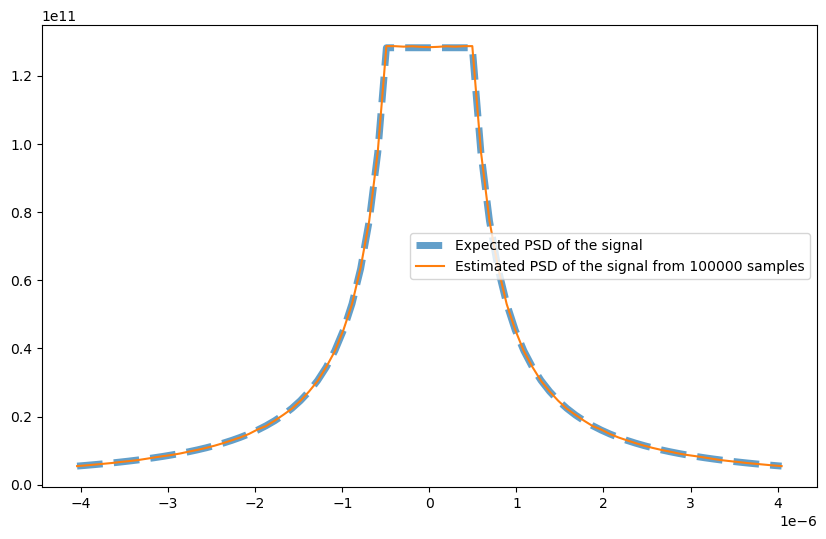

In [15]:
signal_samples_fft = np.fft.fft(np.array(signal_samples), axis=1) 

estimated_PSD = np.fft.fftshift(np.mean(np.abs(signal_samples_fft)**2, axis=0)) * df**2
expected_PSD = np.fft.fftshift((psd_sqrt * df)**2)

delays_shifted = np.fft.fftshift(delays)

plt.figure(figsize=(10,6))
plt.plot(delays_shifted, expected_PSD, label='Expected PSD of the signal', linestyle='--', alpha=0.7, lw=5)
plt.plot(delays_shifted, estimated_PSD, label='Estimated PSD of the signal from {} samples'.format(N_samples))
plt.legend()


#### Generate visibility samples with the isotropic signal (noiseless, baseline length=0)

In [16]:
test_beam_integral = np.sum(test_beam, axis=1) * test_d_Omega
vis_samples = signal_samples * test_beam_integral[None,:]

In [17]:
pspec_estimates = []

N_sample = 10000

obj = nonuniform_pspec(freqs_pspec, 
            normalised_beam=test_beam,
            d_Omega=test_d_Omega, 
            taper='blackman-harris',
            test_with_isotropic_signal=True # We are testing with isotropic signal, so the beam integration is done before outer product
            )
import tqdm
for i in tqdm.tqdm(range(N_sample)):
    vis = vis_samples[i, :]
    wind_coeffs, bias, norms, p_hat = obj.p_hat(vis, vis, flag1, flag2, quad_form="Q")
    pspec_estimates.append(p_hat)

pspec_estimates = np.array(pspec_estimates)

100%|██████████| 10000/10000 [12:10<00:00, 13.69it/s]


In [18]:
true_PSD = expected_PSD
true_windowed_PSD = np.einsum("ij,j->i", wind_coeffs, expected_PSD)

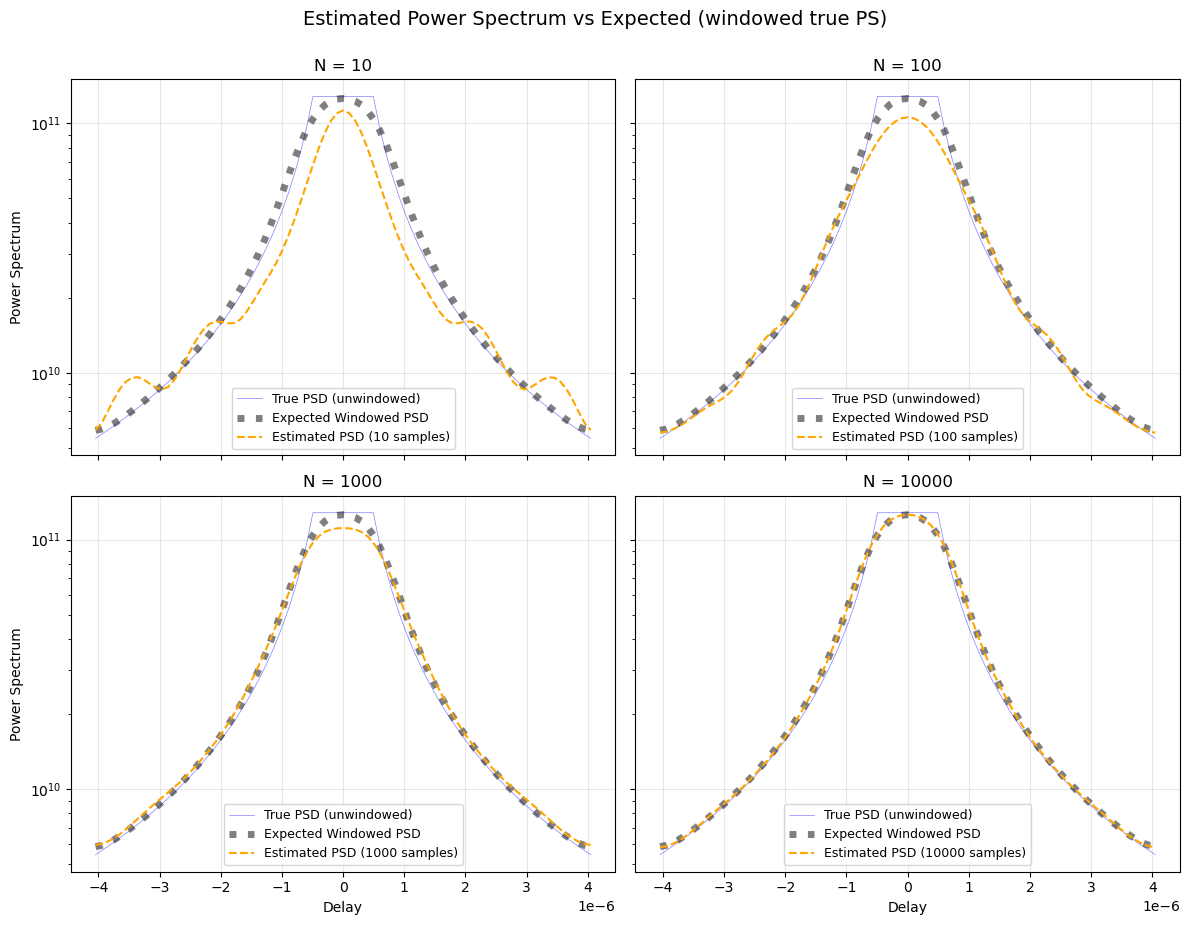

In [19]:
sample_counts = [10, 100, 1000, 10000]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

axes = axes.ravel()


for ax, N_sample in zip(axes, sample_counts):

    pspec_mean = np.mean(pspec_estimates[:N_sample, :], axis=0)

    ax.plot(delays_shifted, true_PSD, label="True PSD (unwindowed)", color="blue", alpha=0.5, lw=0.5)
    ax.plot(delays_shifted, true_windowed_PSD, label="Expected Windowed PSD", linestyle=":", color="k", linewidth=5, alpha=0.5)
    ax.plot(delays_shifted, pspec_mean, label=f"Estimated PSD ({N_sample} samples)", linestyle="--", color="orange")

    ax.set_yscale("log")
    ax.set_title(f"N = {N_sample}")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)


for ax in axes[2:]:
    ax.set_xlabel("Delay")

for ax in axes[::2]:
    ax.set_ylabel("Power Spectrum")


fig.suptitle("Estimated Power Spectrum vs Expected (windowed true PS)", fontsize=14, y=0.95)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [20]:
# Covariance of the Monte Carlo bandpower estimates


# pspec_mean = np.mean(pspec_estimates, axis=0)

# Ndlys = pspec_mean.size

sample_cov = np.cov(pspec_estimates.real.T)

In [29]:
# Theoretical covariance from the response matrices and input power spectrum
bps = expected_PSD
expected_phat_cov = calculate_p_hat_covariance(bps, obj.resp_mat_arr, norms, weighted_noise_cov=None)

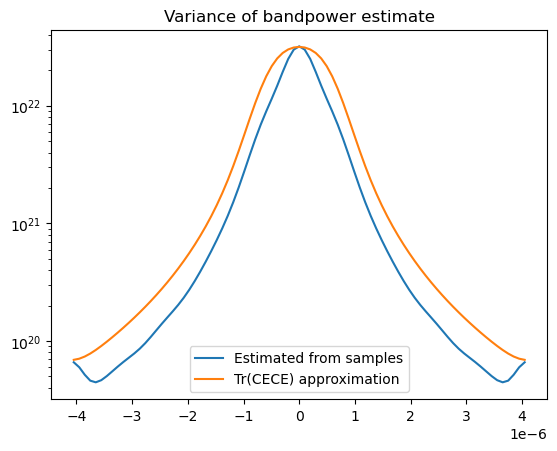

In [39]:
plt.plot(delays_shifted, np.diag(sample_cov.real), label="Estimated from samples")
plt.plot(delays_shifted, np.diag(expected_phat_cov.real), label="Tr(CECE) approximation")
plt.title("Variance of bandpower estimate")
plt.yscale('log')
plt.legend()